In [1]:
import numpy as np
import matplotlib.pyplot as plt

from BoltzmannValueIteration import BoltzmannValueIteration
from SetupDeterministicTransition import *
from SetupRewardTable import *
from GoalInferenceVisualizations import *

# Goal Inference Class

Perform goal inference - In an environment with multiple goals, perform bayesian inference
to determine which goal is most likely from an observer's standpoint, given an observed state 
trajectory sequence

In [2]:
class PerformGoalInference(object):
    def __init__(self, transitionTable, goalPolicies, goalPriors, stateTrajectory):
        self.transitionTable = transitionTable
        self.goalPolicies  = goalPolicies
        self.goalPriors = goalPriors
        self.stateTrajectory = stateTrajectory

    def __call__(self):
        posterior = self.getSequenceOfStateProbabilities()*np.array(self.goalPriors)        
        row_sums = posterior.sum(axis=1, keepdims=True)
        normalizedPosterior = posterior / row_sums
        return(normalizedPosterior)
        
    def getNextStateProbability(self, state, nextState, policy):
        possibleActionsToNextState = [action for action in self.transitionTable[state] \
                                      if nextState in self.transitionTable[state][action]]

        probNextState = sum([self.transitionTable[state][action][nextState]*policy[state][action] \
                             for action in possibleActionsToNextState])
        return(probNextState)
    
    def getSequenceOfStateProbabilities(self):
        probNextState = [self.goalPriors]
        for t, state in enumerate(self.stateTrajectory[:-1]):
            nextState = self.stateTrajectory[t+1]
            probNextState.append([self.getNextStateProbability(state, nextState, goalPolicy) \
                         for goalPolicy in self.goalPolicies])
        observedStateProbs = np.cumprod(np.array(probNextState), axis=0)
        return(observedStateProbs)


In [3]:
gridWidth = 7
gridHeight = 6
allActions = [(1,0), (0,1), (-1,0), (0,-1), (-1,1), (1,-1), (1,1), (-1,-1)]
trapStates = [(3,0), (3,1), (3,2), (3,3)]

In [4]:
#Inputs
gamma = .95
beta = .4
convergenceThreshold = 10e-7
transition = {(0, 0): {(1, 0): {(1, 0): 1},(0, 1): {(0, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(0, 0): 1},(-1, 1): {(0, 0): 1},(1, -1): {(0, 0): 1},(1, 1): {(1, 1): 1},(-1, -1): {(0, 0): 1}},(0, 1): {(1, 0): {(1, 1): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(0, 0): 1},(-1, 1): {(0, 1): 1},(1, -1): {(1, 0): 1},(1, 1): {(1, 2): 1},(-1, -1): {(0, 1): 1}},(0, 2): {(1, 0): {(1, 2): 1},(0, 1): {(0, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(0, 1): 1},(-1, 1): {(0, 2): 1},(1, -1): {(1, 1): 1},(1, 1): {(1, 3): 1},(-1, -1): {(0, 2): 1}},(0, 3): {(1, 0): {(1, 3): 1},(0, 1): {(0, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(0, 2): 1},(-1, 1): {(0, 3): 1},(1, -1): {(1, 2): 1},(1, 1): {(1, 4): 1},(-1, -1): {(0, 3): 1}},(0, 4): {(1, 0): {(1, 4): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(0, 3): 1},(-1, 1): {(0, 4): 1},(1, -1): {(1, 3): 1},(1, 1): {(1, 5): 1},(-1, -1): {(0, 4): 1}},(0, 5): {(1, 0): {(1, 5): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(0, 4): 1},(-1, 1): {(0, 5): 1},(1, -1): {(1, 4): 1},(1, 1): {(0, 5): 1},(-1, -1): {(0, 5): 1}},(1, 0): {(1, 0): {(2, 0): 1},(0, 1): {(1, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(1, 0): 1},(-1, 1): {(0, 1): 1},(1, -1): {(1, 0): 1},(1, 1): {(2, 1): 1},(-1, -1): {(1, 0): 1}},(1, 1): {(1, 0): {(2, 1): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(1, 0): 1},(-1, 1): {(0, 2): 1},(1, -1): {(2, 0): 1},(1, 1): {(2, 2): 1},(-1, -1): {(0, 0): 1}},(1, 2): {(1, 0): {(2, 2): 1},(0, 1): {(1, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(1, 1): 1},(-1, 1): {(0, 3): 1},(1, -1): {(2, 1): 1},(1, 1): {(2, 3): 1},(-1, -1): {(0, 1): 1}},(1, 3): {(1, 0): {(2, 3): 1},(0, 1): {(1, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(1, 2): 1},(-1, 1): {(0, 4): 1},(1, -1): {(2, 2): 1},(1, 1): {(2, 4): 1},(-1, -1): {(0, 2): 1}},(1, 4): {(1, 0): {(2, 4): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(1, 3): 1},(-1, 1): {(0, 5): 1},(1, -1): {(2, 3): 1},(1, 1): {(2, 5): 1},(-1, -1): {(0, 3): 1}},(1, 5): {(1, 0): {(2, 5): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(1, 4): 1},(-1, 1): {(1, 5): 1},(1, -1): {(2, 4): 1},(1, 1): {(1, 5): 1},(-1, -1): {(0, 4): 1}},(2, 0): {(1, 0): {(3, 0): 1},(0, 1): {(2, 1): 1},(-1, 0): {(1, 0): 1},(0, -1): {(2, 0): 1},(-1, 1): {(1, 1): 1},(1, -1): {(2, 0): 1},(1, 1): {(3, 1): 1},(-1, -1): {(2, 0): 1}},(2, 1): {(1, 0): {(3, 1): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 1): 1},(0, -1): {(2, 0): 1},(-1, 1): {(1, 2): 1},(1, -1): {(3, 0): 1},(1, 1): {(3, 2): 1},(-1, -1): {(1, 0): 1}},(2, 2): {(1, 0): {(3, 2): 1},(0, 1): {(2, 3): 1},(-1, 0): {(1, 2): 1},(0, -1): {(2, 1): 1},(-1, 1): {(1, 3): 1},(1, -1): {(3, 1): 1},(1, 1): {(3, 3): 1},(-1, -1): {(1, 1): 1}},(2, 3): {(1, 0): {(3, 3): 1},(0, 1): {(2, 4): 1},(-1, 0): {(1, 3): 1},(0, -1): {(2, 2): 1},(-1, 1): {(1, 4): 1},(1, -1): {(3, 2): 1},(1, 1): {(3, 4): 1},(-1, -1): {(1, 2): 1}},(2, 4): {(1, 0): {(3, 4): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 4): 1},(0, -1): {(2, 3): 1},(-1, 1): {(1, 5): 1},(1, -1): {(3, 3): 1},(1, 1): {(3, 5): 1},(-1, -1): {(1, 3): 1}},(2, 5): {(1, 0): {(3, 5): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 5): 1},(0, -1): {(2, 4): 1},(-1, 1): {(2, 5): 1},(1, -1): {(3, 4): 1},(1, 1): {(2, 5): 1},(-1, -1): {(1, 4): 1}},(3, 0): {(1, 0): {(4, 0): 1},(0, 1): {(3, 1): 1},(-1, 0): {(2, 0): 1},(0, -1): {(3, 0): 1},(-1, 1): {(2, 1): 1},(1, -1): {(3, 0): 1},(1, 1): {(4, 1): 1},(-1, -1): {(3, 0): 1}},(3, 1): {(1, 0): {(4, 1): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 1): 1},(0, -1): {(3, 0): 1},(-1, 1): {(2, 2): 1},(1, -1): {(4, 0): 1},(1, 1): {(4, 2): 1},(-1, -1): {(2, 0): 1}},(3, 2): {(1, 0): {(4, 2): 1},(0, 1): {(3, 3): 1},(-1, 0): {(2, 2): 1},(0, -1): {(3, 1): 1},(-1, 1): {(2, 3): 1},(1, -1): {(4, 1): 1},(1, 1): {(4, 3): 1},(-1, -1): {(2, 1): 1}},(3, 3): {(1, 0): {(4, 3): 1},(0, 1): {(3, 4): 1},(-1, 0): {(2, 3): 1},(0, -1): {(3, 2): 1},(-1, 1): {(2, 4): 1},(1, -1): {(4, 2): 1},(1, 1): {(4, 4): 1},(-1, -1): {(2, 2): 1}},(3, 4): {(1, 0): {(4, 4): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 4): 1},(0, -1): {(3, 3): 1},(-1, 1): {(2, 5): 1},(1, -1): {(4, 3): 1},(1, 1): {(4, 5): 1},(-1, -1): {(2, 3): 1}},(3, 5): {(1, 0): {(4, 5): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 5): 1},(0, -1): {(3, 4): 1},(-1, 1): {(3, 5): 1},(1, -1): {(4, 4): 1},(1, 1): {(3, 5): 1},(-1, -1): {(2, 4): 1}},(4, 0): {(1, 0): {(5, 0): 1},(0, 1): {(4, 1): 1},(-1, 0): {(3, 0): 1},(0, -1): {(4, 0): 1},(-1, 1): {(3, 1): 1},(1, -1): {(4, 0): 1},(1, 1): {(5, 1): 1},(-1, -1): {(4, 0): 1}},(4, 1): {(1, 0): {(5, 1): 1},(0, 1): {(4, 2): 1},(-1, 0): {(3, 1): 1},(0, -1): {(4, 0): 1},(-1, 1): {(3, 2): 1},(1, -1): {(5, 0): 1},(1, 1): {(5, 2): 1},(-1, -1): {(3, 0): 1}},(4, 2): {(1, 0): {(5, 2): 1},(0, 1): {(4, 3): 1},(-1, 0): {(3, 2): 1},(0, -1): {(4, 1): 1},(-1, 1): {(3, 3): 1},(1, -1): {(5, 1): 1},(1, 1): {(5, 3): 1},(-1, -1): {(3, 1): 1}},(4, 3): {(1, 0): {(5, 3): 1},(0, 1): {(4, 4): 1},(-1, 0): {(3, 3): 1},(0, -1): {(4, 2): 1},(-1, 1): {(3, 4): 1},(1, -1): {(5, 2): 1},(1, 1): {(5, 4): 1},(-1, -1): {(3, 2): 1}},(4, 4): {(1, 0): {(5, 4): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 4): 1},(0, -1): {(4, 3): 1},(-1, 1): {(3, 5): 1},(1, -1): {(5, 3): 1},(1, 1): {(5, 5): 1},(-1, -1): {(3, 3): 1}},(4, 5): {(1, 0): {(5, 5): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 5): 1},(0, -1): {(4, 4): 1},(-1, 1): {(4, 5): 1},(1, -1): {(5, 4): 1},(1, 1): {(4, 5): 1},(-1, -1): {(3, 4): 1}},(5, 0): {(1, 0): {(6, 0): 1},(0, 1): {(5, 1): 1},(-1, 0): {(4, 0): 1},(0, -1): {(5, 0): 1},(-1, 1): {(4, 1): 1},(1, -1): {(5, 0): 1},(1, 1): {(6, 1): 1},(-1, -1): {(5, 0): 1}},(5, 1): {(1, 0): {(6, 1): 1},(0, 1): {(5, 2): 1},(-1, 0): {(4, 1): 1},(0, -1): {(5, 0): 1},(-1, 1): {(4, 2): 1},(1, -1): {(6, 0): 1},(1, 1): {(6, 2): 1},(-1, -1): {(4, 0): 1}},(5, 2): {(1, 0): {(6, 2): 1},(0, 1): {(5, 3): 1},(-1, 0): {(4, 2): 1},(0, -1): {(5, 1): 1},(-1, 1): {(4, 3): 1},(1, -1): {(6, 1): 1},(1, 1): {(6, 3): 1},(-1, -1): {(4, 1): 1}},(5, 3): {(1, 0): {(6, 3): 1},(0, 1): {(5, 4): 1},(-1, 0): {(4, 3): 1},(0, -1): {(5, 2): 1},(-1, 1): {(4, 4): 1},(1, -1): {(6, 2): 1},(1, 1): {(6, 4): 1},(-1, -1): {(4, 2): 1}},(5, 4): {(1, 0): {(6, 4): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 4): 1},(0, -1): {(5, 3): 1},(-1, 1): {(4, 5): 1},(1, -1): {(6, 3): 1},(1, 1): {(6, 5): 1},(-1, -1): {(4, 3): 1}},(5, 5): {(1, 0): {(6, 5): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 5): 1},(0, -1): {(5, 4): 1},(-1, 1): {(5, 5): 1},(1, -1): {(6, 4): 1},(1, 1): {(5, 5): 1},(-1, -1): {(4, 4): 1}},(6, 0): {(1, 0): {(6, 0): 1},(0, 1): {(6, 1): 1},(-1, 0): {(5, 0): 1},(0, -1): {(6, 0): 1},(-1, 1): {(5, 1): 1},(1, -1): {(6, 0): 1},(1, 1): {(6, 0): 1},(-1, -1): {(6, 0): 1}},(6, 1): {(1, 0): {(6, 1): 1},(0, 1): {(6, 2): 1},(-1, 0): {(5, 1): 1},(0, -1): {(6, 0): 1},(-1, 1): {(5, 2): 1},(1, -1): {(6, 1): 1},(1, 1): {(6, 1): 1},(-1, -1): {(5, 0): 1}},(6, 2): {(1, 0): {(6, 2): 1},(0, 1): {(6, 3): 1},(-1, 0): {(5, 2): 1},(0, -1): {(6, 1): 1},(-1, 1): {(5, 3): 1},(1, -1): {(6, 2): 1},(1, 1): {(6, 2): 1},(-1, -1): {(5, 1): 1}},(6, 3): {(1, 0): {(6, 3): 1},(0, 1): {(6, 4): 1},(-1, 0): {(5, 3): 1},(0, -1): {(6, 2): 1},(-1, 1): {(5, 4): 1},(1, -1): {(6, 3): 1},(1, 1): {(6, 3): 1},(-1, -1): {(5, 2): 1}},(6, 4): {(1, 0): {(6, 4): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 4): 1},(0, -1): {(6, 3): 1},(-1, 1): {(5, 5): 1},(1, -1): {(6, 4): 1},(1, 1): {(6, 4): 1},(-1, -1): {(5, 3): 1}},(6, 5): {(1, 0): {(6, 5): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 5): 1},(0, -1): {(6, 4): 1},(-1, 1): {(6, 5): 1},(1, -1): {(6, 5): 1},(1, 1): {(6, 5): 1},(-1, -1): {(5, 4): 1}}}

#Observed Trajectories
trajectoryToGoalA = [(0,0), (1,1), (1,2), (2,3), (3,4), (4,4), (5,4), (6,4)]
trajectoryToGoalB = [(0,0), (1,1), (2,2), (2,3), (3,4), (4,3), (5,2), (6,1)]
trajectoryToGoalC = [(0,0), (0,1), (1,2), (1,3), (1,4), (1,5)]

#Environment 1: Solid  Barrier
rewardA = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): -1.0},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1.0},(0, -1): {(1, 4): -1.0},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): -1.4142135623730951},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): -1.4142135623730951}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 2): -100},(1, -1): {(4, 0): -100},(1, 1): {(4, 2): -100},(-1, -1): {(2, 0): -100}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1.0},(-1, 0): {(5, 1): -1.0},(0, -1): {(6, 0): -1.0},(-1, 1): {(5, 2): -1.4142135623730951},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): -1.4142135623730951}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): 10},(-1, 0): {(5, 4): 10},(0, -1): {(6, 3): 10},(-1, 1): {(5, 5): 10},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): 10}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}
rewardB = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): -1.0},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1.0},(0, -1): {(1, 4): -1.0},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): -1.4142135623730951},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): -1.4142135623730951}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 2): -100},(1, -1): {(4, 0): -100},(1, 1): {(4, 2): -100},(-1, -1): {(2, 0): -100}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): 10},(-1, 0): {(5, 1): 10},(0, -1): {(6, 0): 10},(-1, 1): {(5, 2): 10},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): 10}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1.0},(-1, 0): {(5, 4): -1.0},(0, -1): {(6, 3): -1.0},(-1, 1): {(5, 5): -1.4142135623730951},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): -1.4142135623730951}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}
rewardC = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): 10},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): 10},(0, -1): {(1, 4): 10},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): 10},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): 10}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 2): -100},(1, -1): {(4, 0): -100},(1, 1): {(4, 2): -100},(-1, -1): {(2, 0): -100}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1.0},(-1, 0): {(5, 1): -1.0},(0, -1): {(6, 0): -1.0},(-1, 1): {(5, 2): -1.4142135623730951},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): -1.4142135623730951}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1.0},(-1, 0): {(5, 4): -1.0},(0, -1): {(6, 3): -1.0},(-1, 1): {(5, 5): -1.4142135623730951},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): -1.4142135623730951}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}

#Environment 2: Barrier with a Gap
rewardAGap = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): -1.0},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1.0},(0, -1): {(1, 4): -1.0},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): -1.4142135623730951},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): -1.4142135623730951}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -1.0},(0, 1): {(3, 2): -1.0},(-1, 0): {(2, 1): -1.0},(0, -1): {(3, 0): -1.0},(-1, 1): {(2, 2): -1.4142135623730951},(1, -1): {(4, 0): -1.4142135623730951},(1, 1): {(4, 2): -1.4142135623730951},(-1, -1): {(2, 0): -1.4142135623730951}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1.0},(-1, 0): {(5, 1): -1.0},(0, -1): {(6, 0): -1.0},(-1, 1): {(5, 2): -1.4142135623730951},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): -1.4142135623730951}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): 10},(-1, 0): {(5, 4): 10},(0, -1): {(6, 3): 10},(-1, 1): {(5, 5): 10},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): 10}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}
rewardBGap = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): -1.0},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1.0},(0, -1): {(1, 4): -1.0},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): -1.4142135623730951},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): -1.4142135623730951}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -1.0},(0, 1): {(3, 2): -1.0},(-1, 0): {(2, 1): -1.0},(0, -1): {(3, 0): -1.0},(-1, 1): {(2, 2): -1.4142135623730951},(1, -1): {(4, 0): -1.4142135623730951},(1, 1): {(4, 2): -1.4142135623730951},(-1, -1): {(2, 0): -1.4142135623730951}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): 10},(-1, 0): {(5, 1): 10},(0, -1): {(6, 0): 10},(-1, 1): {(5, 2): 10},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): 10}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1.0},(-1, 0): {(5, 4): -1.0},(0, -1): {(6, 3): -1.0},(-1, 1): {(5, 5): -1.4142135623730951},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): -1.4142135623730951}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}
rewardCGap = {(0, 0): {(1, 0): {(1, 0): -1.0},(0, 1): {(0, 1): -1.0},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(-1, 1): {(0, 0): -1},(1, -1): {(0, 0): -1},(1, 1): {(1, 1): -1.4142135623730951},(-1, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1.0},(0, 1): {(0, 2): -1.0},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1.0},(-1, 1): {(0, 1): -1},(1, -1): {(1, 0): -1.4142135623730951},(1, 1): {(1, 2): -1.4142135623730951},(-1, -1): {(0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1.0},(0, 1): {(0, 3): -1.0},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1.0},(-1, 1): {(0, 2): -1},(1, -1): {(1, 1): -1.4142135623730951},(1, 1): {(1, 3): -1.4142135623730951},(-1, -1): {(0, 2): -1}},(0, 3): {(1, 0): {(1, 3): -1.0},(0, 1): {(0, 4): -1.0},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1.0},(-1, 1): {(0, 3): -1},(1, -1): {(1, 2): -1.4142135623730951},(1, 1): {(1, 4): -1.4142135623730951},(-1, -1): {(0, 3): -1}},(0, 4): {(1, 0): {(1, 4): -1.0},(0, 1): {(0, 5): -1.0},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1.0},(-1, 1): {(0, 4): -1},(1, -1): {(1, 3): -1.4142135623730951},(1, 1): {(1, 5): -1.4142135623730951},(-1, -1): {(0, 4): -1}},(0, 5): {(1, 0): {(1, 5): -1.0},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1.0},(-1, 1): {(0, 5): -1},(1, -1): {(1, 4): -1.4142135623730951},(1, 1): {(0, 5): -1},(-1, -1): {(0, 5): -1}},(1, 0): {(1, 0): {(2, 0): -1.0},(0, 1): {(1, 1): -1.0},(-1, 0): {(0, 0): -1.0},(0, -1): {(1, 0): -1},(-1, 1): {(0, 1): -1.4142135623730951},(1, -1): {(1, 0): -1},(1, 1): {(2, 1): -1.4142135623730951},(-1, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): -1.0},(0, 1): {(1, 2): -1.0},(-1, 0): {(0, 1): -1.0},(0, -1): {(1, 0): -1.0},(-1, 1): {(0, 2): -1.4142135623730951},(1, -1): {(2, 0): -1.4142135623730951},(1, 1): {(2, 2): -1.4142135623730951},(-1, -1): {(0, 0): -1.4142135623730951}},(1, 2): {(1, 0): {(2, 2): -1.0},(0, 1): {(1, 3): -1.0},(-1, 0): {(0, 2): -1.0},(0, -1): {(1, 1): -1.0},(-1, 1): {(0, 3): -1.4142135623730951},(1, -1): {(2, 1): -1.4142135623730951},(1, 1): {(2, 3): -1.4142135623730951},(-1, -1): {(0, 1): -1.4142135623730951}},(1, 3): {(1, 0): {(2, 3): -1.0},(0, 1): {(1, 4): -1.0},(-1, 0): {(0, 3): -1.0},(0, -1): {(1, 2): -1.0},(-1, 1): {(0, 4): -1.4142135623730951},(1, -1): {(2, 2): -1.4142135623730951},(1, 1): {(2, 4): -1.4142135623730951},(-1, -1): {(0, 2): -1.4142135623730951}},(1, 4): {(1, 0): {(2, 4): -1.0},(0, 1): {(1, 5): -1.0},(-1, 0): {(0, 4): -1.0},(0, -1): {(1, 3): -1.0},(-1, 1): {(0, 5): -1.4142135623730951},(1, -1): {(2, 3): -1.4142135623730951},(1, 1): {(2, 5): -1.4142135623730951},(-1, -1): {(0, 3): -1.4142135623730951}},(1, 5): {(1, 0): {(2, 5): 10},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): 10},(0, -1): {(1, 4): 10},(-1, 1): {(1, 5): -1},(1, -1): {(2, 4): 10},(1, 1): {(1, 5): -1},(-1, -1): {(0, 4): 10}},(2, 0): {(1, 0): {(3, 0): -1.0},(0, 1): {(2, 1): -1.0},(-1, 0): {(1, 0): -1.0},(0, -1): {(2, 0): -1},(-1, 1): {(1, 1): -1.4142135623730951},(1, -1): {(2, 0): -1},(1, 1): {(3, 1): -1.4142135623730951},(-1, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1.0},(0, 1): {(2, 2): -1.0},(-1, 0): {(1, 1): -1.0},(0, -1): {(2, 0): -1.0},(-1, 1): {(1, 2): -1.4142135623730951},(1, -1): {(3, 0): -1.4142135623730951},(1, 1): {(3, 2): -1.4142135623730951},(-1, -1): {(1, 0): -1.4142135623730951}},(2, 2): {(1, 0): {(3, 2): -1.0},(0, 1): {(2, 3): -1.0},(-1, 0): {(1, 2): -1.0},(0, -1): {(2, 1): -1.0},(-1, 1): {(1, 3): -1.4142135623730951},(1, -1): {(3, 1): -1.4142135623730951},(1, 1): {(3, 3): -1.4142135623730951},(-1, -1): {(1, 1): -1.4142135623730951}},(2, 3): {(1, 0): {(3, 3): -1.0},(0, 1): {(2, 4): -1.0},(-1, 0): {(1, 3): -1.0},(0, -1): {(2, 2): -1.0},(-1, 1): {(1, 4): -1.4142135623730951},(1, -1): {(3, 2): -1.4142135623730951},(1, 1): {(3, 4): -1.4142135623730951},(-1, -1): {(1, 2): -1.4142135623730951}},(2, 4): {(1, 0): {(3, 4): -1.0},(0, 1): {(2, 5): -1.0},(-1, 0): {(1, 4): -1.0},(0, -1): {(2, 3): -1.0},(-1, 1): {(1, 5): -1.4142135623730951},(1, -1): {(3, 3): -1.4142135623730951},(1, 1): {(3, 5): -1.4142135623730951},(-1, -1): {(1, 3): -1.4142135623730951}},(2, 5): {(1, 0): {(3, 5): -1.0},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1.0},(0, -1): {(2, 4): -1.0},(-1, 1): {(2, 5): -1},(1, -1): {(3, 4): -1.4142135623730951},(1, 1): {(2, 5): -1},(-1, -1): {(1, 4): -1.4142135623730951}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(-1, 1): {(2, 1): -100},(1, -1): {(3, 0): -100},(1, 1): {(4, 1): -100},(-1, -1): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -1.0},(0, 1): {(3, 2): -1.0},(-1, 0): {(2, 1): -1.0},(0, -1): {(3, 0): -1.0},(-1, 1): {(2, 2): -1.4142135623730951},(1, -1): {(4, 0): -1.4142135623730951},(1, 1): {(4, 2): -1.4142135623730951},(-1, -1): {(2, 0): -1.4142135623730951}},(3, 2): {(1, 0): {(4, 2): -100},(0, 1): {(3, 3): -100},(-1, 0): {(2, 2): -100},(0, -1): {(3, 1): -100},(-1, 1): {(2, 3): -100},(1, -1): {(4, 1): -100},(1, 1): {(4, 3): -100},(-1, -1): {(2, 1): -100}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(-1, 1): {(2, 4): -100},(1, -1): {(4, 2): -100},(1, 1): {(4, 4): -100},(-1, -1): {(2, 2): -100}},(3, 4): {(1, 0): {(4, 4): -1.0},(0, 1): {(3, 5): -1.0},(-1, 0): {(2, 4): -1.0},(0, -1): {(3, 3): -1.0},(-1, 1): {(2, 5): -1.4142135623730951},(1, -1): {(4, 3): -1.4142135623730951},(1, 1): {(4, 5): -1.4142135623730951},(-1, -1): {(2, 3): -1.4142135623730951}},(3, 5): {(1, 0): {(4, 5): -1.0},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1.0},(0, -1): {(3, 4): -1.0},(-1, 1): {(3, 5): -1},(1, -1): {(4, 4): -1.4142135623730951},(1, 1): {(3, 5): -1},(-1, -1): {(2, 4): -1.4142135623730951}},(4, 0): {(1, 0): {(5, 0): -1.0},(0, 1): {(4, 1): -1.0},(-1, 0): {(3, 0): -1.0},(0, -1): {(4, 0): -1},(-1, 1): {(3, 1): -1.4142135623730951},(1, -1): {(4, 0): -1},(1, 1): {(5, 1): -1.4142135623730951},(-1, -1): {(4, 0): -1}},(4, 1): {(1, 0): {(5, 1): -1.0},(0, 1): {(4, 2): -1.0},(-1, 0): {(3, 1): -1.0},(0, -1): {(4, 0): -1.0},(-1, 1): {(3, 2): -1.4142135623730951},(1, -1): {(5, 0): -1.4142135623730951},(1, 1): {(5, 2): -1.4142135623730951},(-1, -1): {(3, 0): -1.4142135623730951}},(4, 2): {(1, 0): {(5, 2): -1.0},(0, 1): {(4, 3): -1.0},(-1, 0): {(3, 2): -1.0},(0, -1): {(4, 1): -1.0},(-1, 1): {(3, 3): -1.4142135623730951},(1, -1): {(5, 1): -1.4142135623730951},(1, 1): {(5, 3): -1.4142135623730951},(-1, -1): {(3, 1): -1.4142135623730951}},(4, 3): {(1, 0): {(5, 3): -1.0},(0, 1): {(4, 4): -1.0},(-1, 0): {(3, 3): -1.0},(0, -1): {(4, 2): -1.0},(-1, 1): {(3, 4): -1.4142135623730951},(1, -1): {(5, 2): -1.4142135623730951},(1, 1): {(5, 4): -1.4142135623730951},(-1, -1): {(3, 2): -1.4142135623730951}},(4, 4): {(1, 0): {(5, 4): -1.0},(0, 1): {(4, 5): -1.0},(-1, 0): {(3, 4): -1.0},(0, -1): {(4, 3): -1.0},(-1, 1): {(3, 5): -1.4142135623730951},(1, -1): {(5, 3): -1.4142135623730951},(1, 1): {(5, 5): -1.4142135623730951},(-1, -1): {(3, 3): -1.4142135623730951}},(4, 5): {(1, 0): {(5, 5): -1.0},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1.0},(0, -1): {(4, 4): -1.0},(-1, 1): {(4, 5): -1},(1, -1): {(5, 4): -1.4142135623730951},(1, 1): {(4, 5): -1},(-1, -1): {(3, 4): -1.4142135623730951}},(5, 0): {(1, 0): {(6, 0): -1.0},(0, 1): {(5, 1): -1.0},(-1, 0): {(4, 0): -1.0},(0, -1): {(5, 0): -1},(-1, 1): {(4, 1): -1.4142135623730951},(1, -1): {(5, 0): -1},(1, 1): {(6, 1): -1.4142135623730951},(-1, -1): {(5, 0): -1}},(5, 1): {(1, 0): {(6, 1): -1.0},(0, 1): {(5, 2): -1.0},(-1, 0): {(4, 1): -1.0},(0, -1): {(5, 0): -1.0},(-1, 1): {(4, 2): -1.4142135623730951},(1, -1): {(6, 0): -1.4142135623730951},(1, 1): {(6, 2): -1.4142135623730951},(-1, -1): {(4, 0): -1.4142135623730951}},(5, 2): {(1, 0): {(6, 2): -1.0},(0, 1): {(5, 3): -1.0},(-1, 0): {(4, 2): -1.0},(0, -1): {(5, 1): -1.0},(-1, 1): {(4, 3): -1.4142135623730951},(1, -1): {(6, 1): -1.4142135623730951},(1, 1): {(6, 3): -1.4142135623730951},(-1, -1): {(4, 1): -1.4142135623730951}},(5, 3): {(1, 0): {(6, 3): -1.0},(0, 1): {(5, 4): -1.0},(-1, 0): {(4, 3): -1.0},(0, -1): {(5, 2): -1.0},(-1, 1): {(4, 4): -1.4142135623730951},(1, -1): {(6, 2): -1.4142135623730951},(1, 1): {(6, 4): -1.4142135623730951},(-1, -1): {(4, 2): -1.4142135623730951}},(5, 4): {(1, 0): {(6, 4): -1.0},(0, 1): {(5, 5): -1.0},(-1, 0): {(4, 4): -1.0},(0, -1): {(5, 3): -1.0},(-1, 1): {(4, 5): -1.4142135623730951},(1, -1): {(6, 3): -1.4142135623730951},(1, 1): {(6, 5): -1.4142135623730951},(-1, -1): {(4, 3): -1.4142135623730951}},(5, 5): {(1, 0): {(6, 5): -1.0},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1.0},(0, -1): {(5, 4): -1.0},(-1, 1): {(5, 5): -1},(1, -1): {(6, 4): -1.4142135623730951},(1, 1): {(5, 5): -1},(-1, -1): {(4, 4): -1.4142135623730951}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1.0},(-1, 0): {(5, 0): -1.0},(0, -1): {(6, 0): -1},(-1, 1): {(5, 1): -1.4142135623730951},(1, -1): {(6, 0): -1},(1, 1): {(6, 0): -1},(-1, -1): {(6, 0): -1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1.0},(-1, 0): {(5, 1): -1.0},(0, -1): {(6, 0): -1.0},(-1, 1): {(5, 2): -1.4142135623730951},(1, -1): {(6, 1): -1},(1, 1): {(6, 1): -1},(-1, -1): {(5, 0): -1.4142135623730951}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1.0},(-1, 0): {(5, 2): -1.0},(0, -1): {(6, 1): -1.0},(-1, 1): {(5, 3): -1.4142135623730951},(1, -1): {(6, 2): -1},(1, 1): {(6, 2): -1},(-1, -1): {(5, 1): -1.4142135623730951}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1.0},(-1, 0): {(5, 3): -1.0},(0, -1): {(6, 2): -1.0},(-1, 1): {(5, 4): -1.4142135623730951},(1, -1): {(6, 3): -1},(1, 1): {(6, 3): -1},(-1, -1): {(5, 2): -1.4142135623730951}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1.0},(-1, 0): {(5, 4): -1.0},(0, -1): {(6, 3): -1.0},(-1, 1): {(5, 5): -1.4142135623730951},(1, -1): {(6, 4): -1},(1, 1): {(6, 4): -1},(-1, -1): {(5, 3): -1.4142135623730951}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1.0},(0, -1): {(6, 4): -1.0},(-1, 1): {(6, 5): -1},(1, -1): {(6, 5): -1},(1, 1): {(6, 5): -1},(-1, -1): {(5, 4): -1.4142135623730951}}}

# Environment 1 - Solid Barrier

Policies for each goal in environment 1

In [5]:
valueA = {state:0 for state in rewardA.keys()}
goalStateA = (6,4)
getPolicyA = BoltzmannValueIteration(transition, rewardA, valueA, convergenceThreshold, gamma, beta)
optimalValuesA, policyA = getPolicyA()

valueB = {state:0 for state in rewardB.keys()}
goalStateB = (6,1)
getPolicyB = BoltzmannValueIteration(transition, rewardB, valueB, convergenceThreshold, gamma, beta)
optimalValuesB, policyB = getPolicyB()

valueC = {state:0 for state in rewardC.keys()}
goalStateC = (1,5)
getPolicyC = BoltzmannValueIteration(transition, rewardC, valueC, convergenceThreshold, gamma, beta)
optimalValuesC, policyC = getPolicyC()

In [7]:
environment1Policies = [policyA, policyB, policyC]
environment1Priors = [1/3, 1/3, 1/3]

## Plotting Posteriors

In [9]:
def plotPosteriors(posteriors, labels=['A', 'B', 'C']):
    x = range(len(posteriors[:, 0]))

    plt.plot(x, posteriors[:,0])
    plt.plot(x, posteriors[:,1])
    plt.plot(x, posteriors[:,2])

    plt.legend(labels)
    plt.show()

## Goal Inference Trajectory A

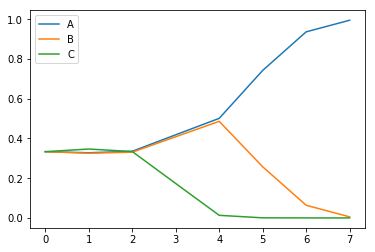

In [10]:
inferGoalA = PerformGoalInference(transition, environment1Policies, environment1Priors, trajectoryToGoalA)
posteriorsToGoalA = inferGoalA()
plotPosteriors(posteriorsToGoalA)

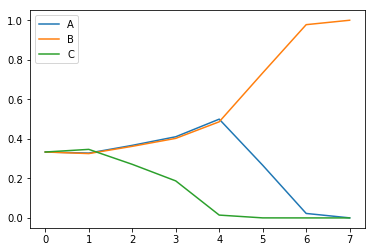

In [11]:
inferGoalB = PerformGoalInference(transition, environment1Policies, environment1Priors, trajectoryToGoalB)
posteriorsToGoalB = inferGoalB()
plotPosteriors(posteriorsToGoalB)

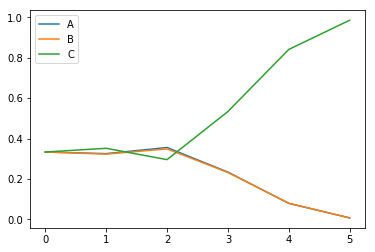

In [12]:
inferGoalC = PerformGoalInference(transition, environment1Policies, environment1Priors, trajectoryToGoalC)
posteriorsToGoalC = inferGoalC()
plotPosteriors(posteriorsToGoalC)

# Environment 2

In [13]:
valueAGap = {state:0 for state in rewardAGap.keys()}
goalStateAGap = (6,4)
getPolicyAGap = BoltzmannValueIteration(transition, rewardAGap, valueAGap, convergenceThreshold, gamma, beta)
optimalValuesAGap, policyAGap = getPolicyAGap()

In [14]:
valueBGap = {state:0 for state in rewardBGap.keys()}
goalStateBGap = (6,1)
getPolicyBGap = BoltzmannValueIteration(transition, rewardBGap, valueBGap, convergenceThreshold, gamma, beta)
optimalValuesBGap, policyBGap= getPolicyBGap()

## Value and Policy

In [15]:
valueCGap = {state:0 for state in rewardCGap.keys()}
goalStateCGap = (6,1)
getPolicyCGap = BoltzmannValueIteration(transition, rewardCGap, valueCGap, convergenceThreshold, gamma, beta)
optimalValuesCGap, policyCGap= getPolicyCGap()

In [16]:
environment2Policies = [policyAGap, policyBGap, policyCGap]
environment2Priors = [1/3, 1/3, 1/3]

## Goal Inference Trajectory to A

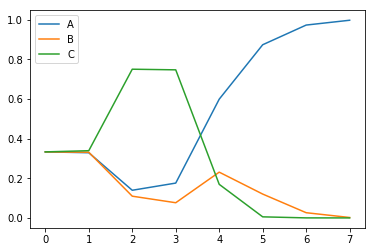

In [17]:
inferGoalAGap = PerformGoalInference(transition, environment2Policies, environment2Priors, trajectoryToGoalA)
posteriorsToGoalAGap = inferGoalAGap()
plotPosteriors(posteriorsToGoalAGap)

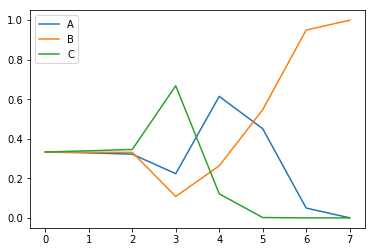

In [18]:
inferGoalBGap = PerformGoalInference(transition, environment2Policies, environment2Priors, trajectoryToGoalB)
posteriorsToGoalBGap = inferGoalBGap()
plotPosteriors(posteriorsToGoalBGap)

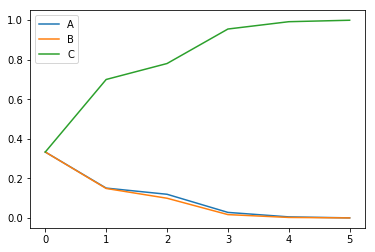

In [19]:
inferGoalCGap = PerformGoalInference(transition, environment2Policies, environment2Priors, trajectoryToGoalC)
posteriorsToGoalCGap = inferGoalCGap()
plotPosteriors(posteriorsToGoalCGap)

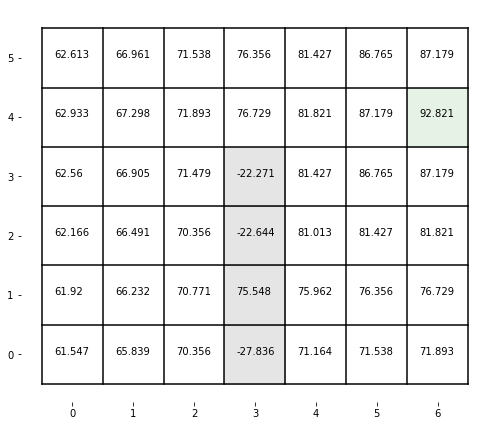

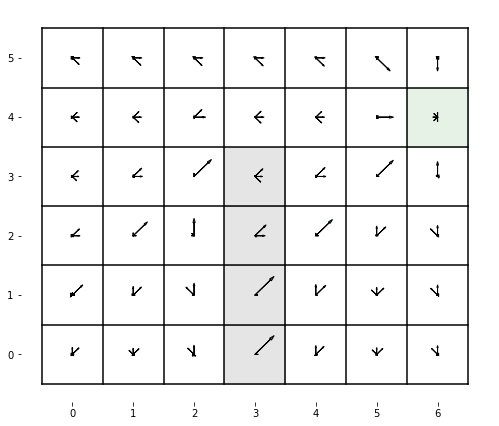

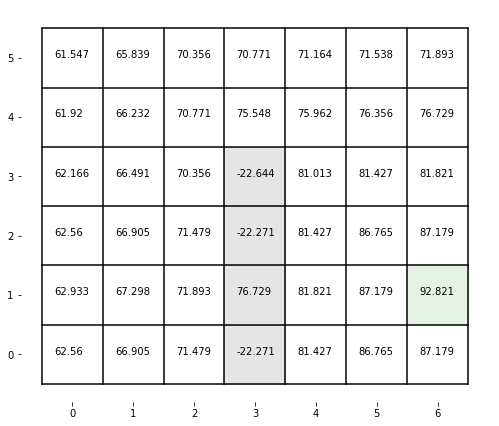

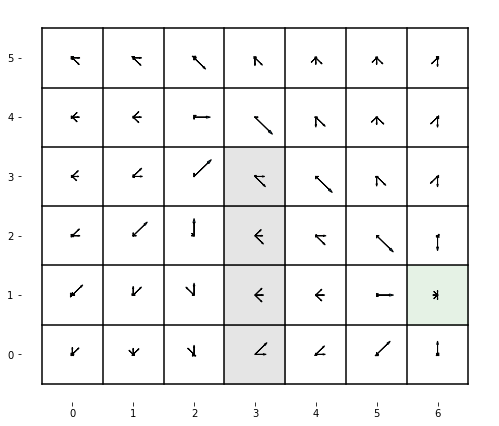

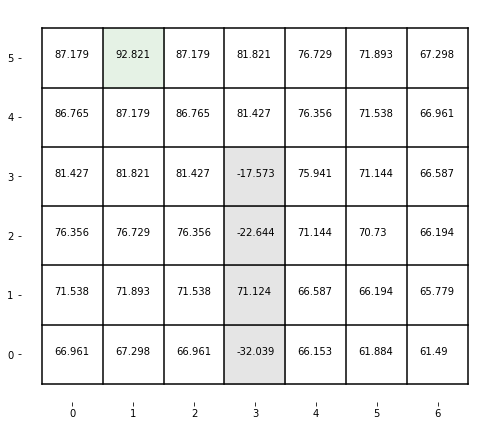

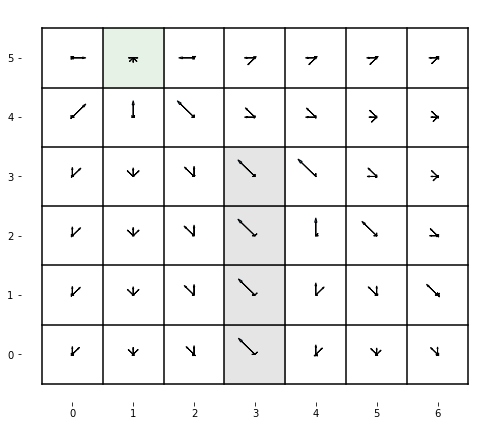

In [20]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateA, trapStates = trapStates, valueTable = optimalValuesAGap)
visualizePolicy(gridWidth, gridHeight, goalStateA, trapStates, policyA)

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateB, trapStates = trapStates, valueTable = optimalValuesBGap)
visualizePolicy(gridWidth, gridHeight, goalStateB, trapStates, policyB)

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateC, trapStates = trapStates, valueTable = optimalValuesCGap)
visualizePolicy(gridWidth, gridHeight, goalStateC, trapStates, policyC)

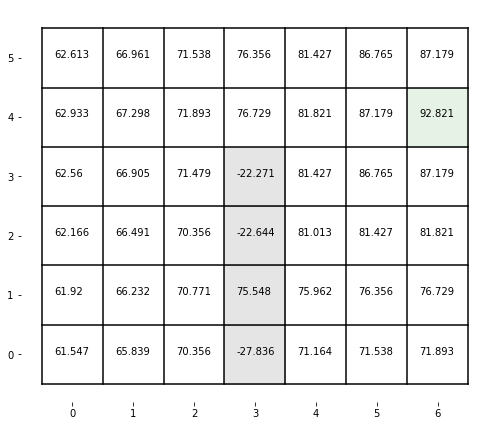

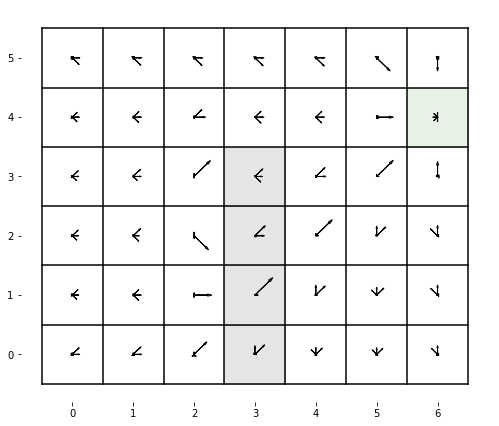

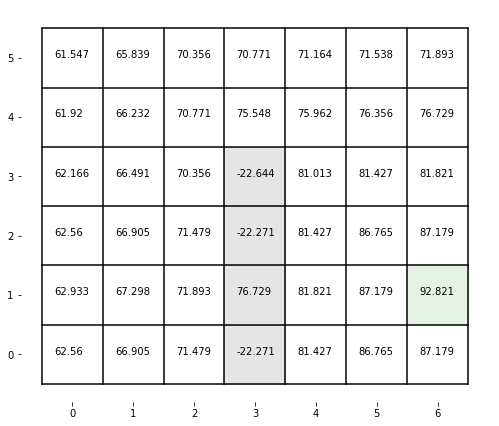

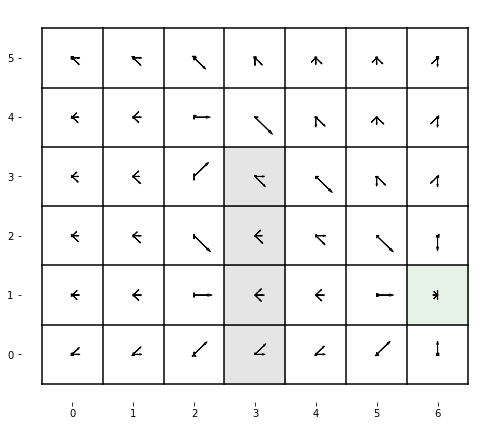

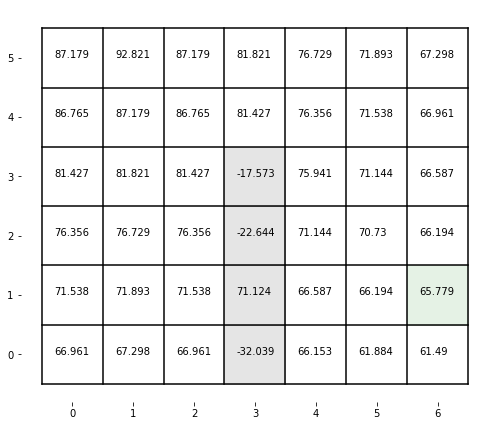

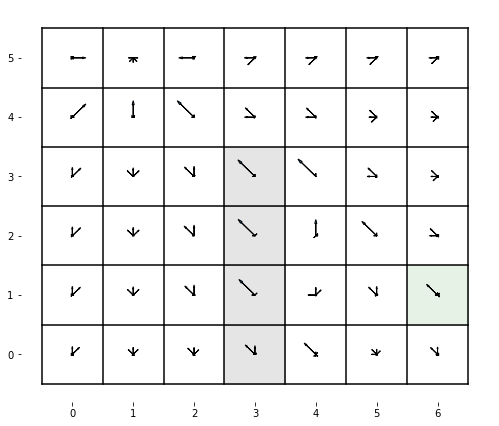

In [21]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateAGap, trapStates = trapStates, valueTable = optimalValuesAGap)
visualizePolicy(gridWidth, gridHeight, goalStateAGap, trapStates, policyAGap)

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateBGap, trapStates = trapStates, valueTable = optimalValuesBGap)
visualizePolicy(gridWidth, gridHeight, goalStateBGap, trapStates, policyBGap)

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateCGap, trapStates = trapStates, valueTable = optimalValuesCGap)
visualizePolicy(gridWidth, gridHeight, goalStateCGap, trapStates, policyCGap)